In [2]:

import math
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from IPython.display import display

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import DateOffset

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

import warnings 
warnings.filterwarnings('ignore')

In [3]:

df = pd.read_csv('Downloads\ETH-USD.csv', usecols=['Date','Adj Close'])
df.columns = ['Date','Price']
variable='Price'
df.loc[:,'Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,Price
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003



Inference: The Datset consists of 1 features & 1577 samples.


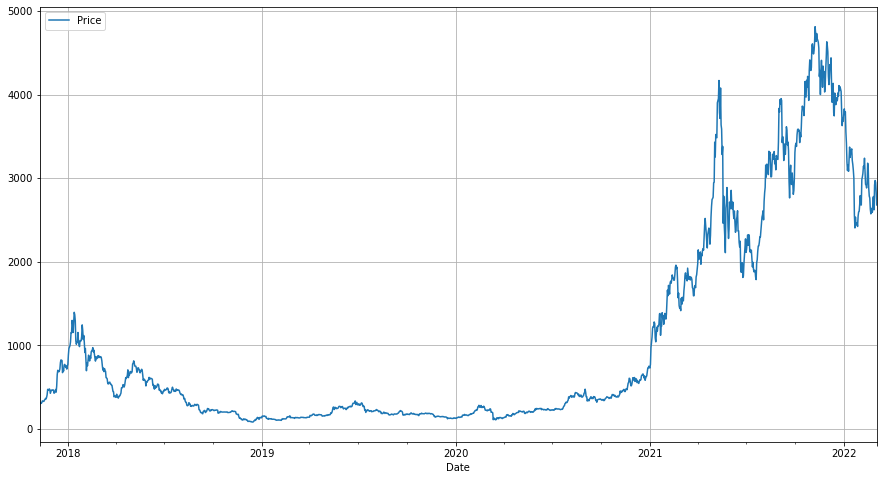

In [4]:
#Plotting Timeseries

df.plot()
plt.grid()
plt.show()

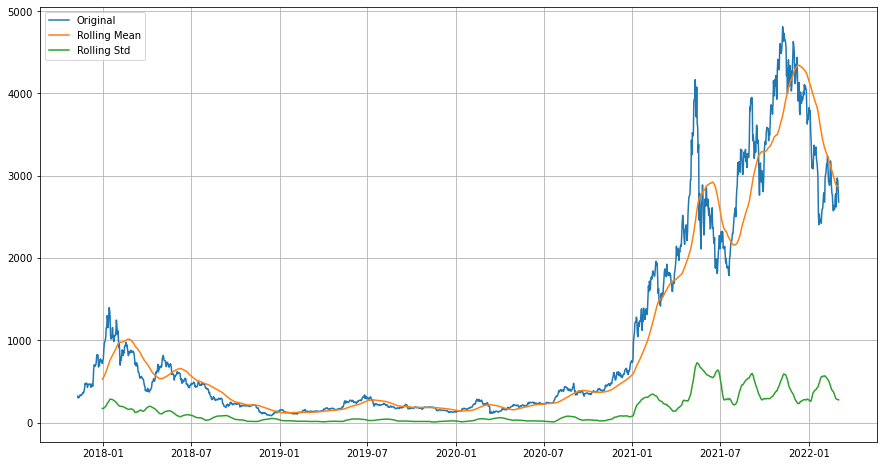

T Statistic             -0.761687
P-Value                  0.830118
#Lags Used              17.000000
#Observations Used    1559.000000
Critical value 1%       -3.434551
Critical value 5%       -2.863396
Critical value 10%      -2.567758
dtype: float64


In [5]:
#Stationary Check

def Staionarity_Check(ts):
    plt.plot(ts, label='Original')
    plt.plot(ts.rolling(window=52, center=False).mean(), label='Rolling Mean')
    plt.plot(ts.rolling(window=52, center=False).std(), label='Rolling Std')
    plt.grid()
    plt.legend()
    plt.show()
    
    adf = adfuller(ts, autolag='AIC')
    padf = pd.Series(adf[:4], index=['T Statistic','P-Value','#Lags Used','#Observations Used'])
    for k,v in adf[4].items():
        padf['Critical value {}'.format(k)]=v
    print(padf)
    
Staionarity_Check(df[variable])

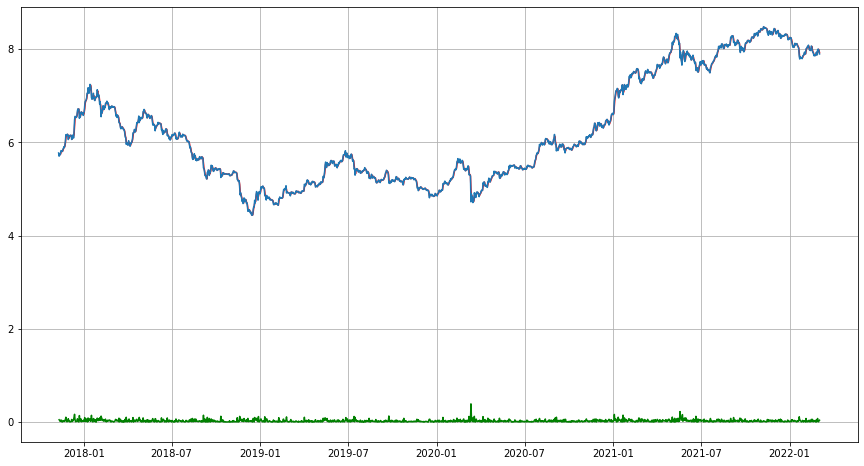

In [6]:
#Decomposing using moving average

tsl = np.log(df)
ma = tsl.rolling(window=2).mean()
ms = tsl.rolling(window=2).std()

plt.plot(ma, c='r')#, center=False)
plt.plot(ms, c='g')
plt.plot(tsl)
plt.grid()
plt.show()

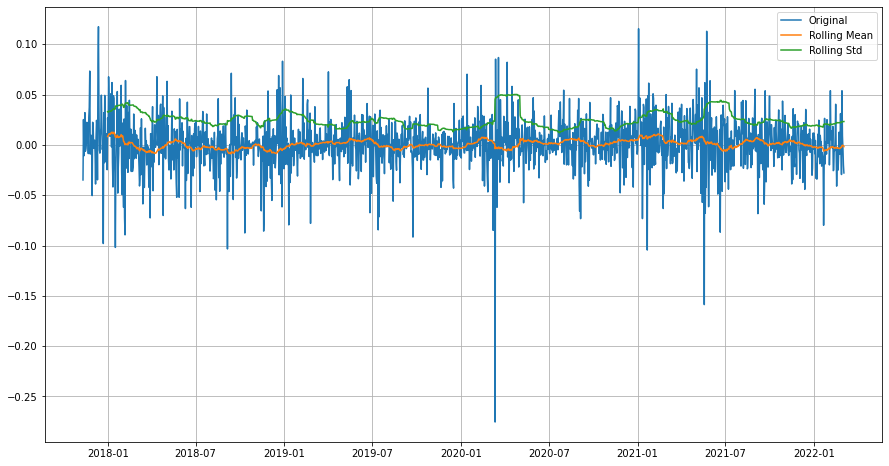

T Statistic          -1.182689e+01
P-Value               8.163244e-22
#Lags Used            9.000000e+00
#Observations Used    1.566000e+03
Critical value 1%    -3.434533e+00
Critical value 5%    -2.863387e+00
Critical value 10%   -2.567754e+00
dtype: float64


In [7]:
# Stationarity Check for Decomposed Time Series

tsl - np.log(df)
ma = tsl.rolling(window=2, center=False).mean()

tslma = tsl - ma
tslma = tslma.dropna()
Staionarity_Check(tslma)

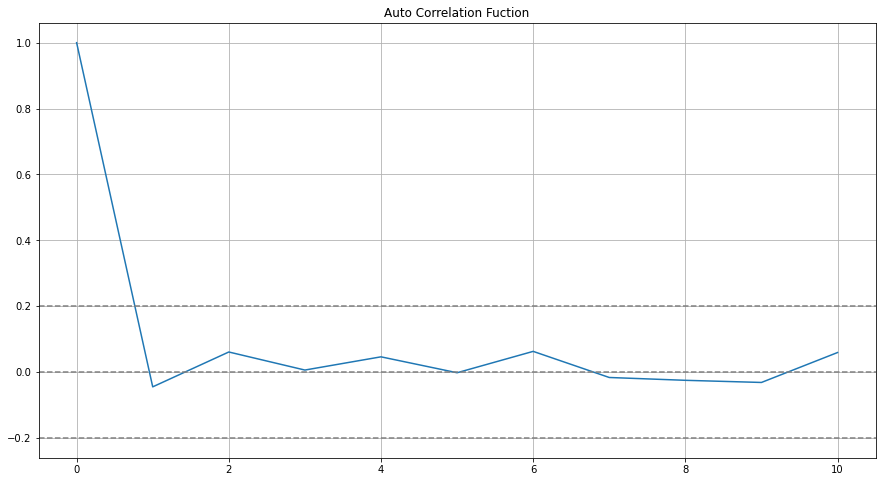

In [8]:
#Auto Correlation Fuction #q

plt.plot(np.arange(acf(tslma, nlags=10,fft=True).shape[0]),acf(tslma, nlags=10, fft=True))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Auto Correlation Fuction')
plt.grid()
plt.show()

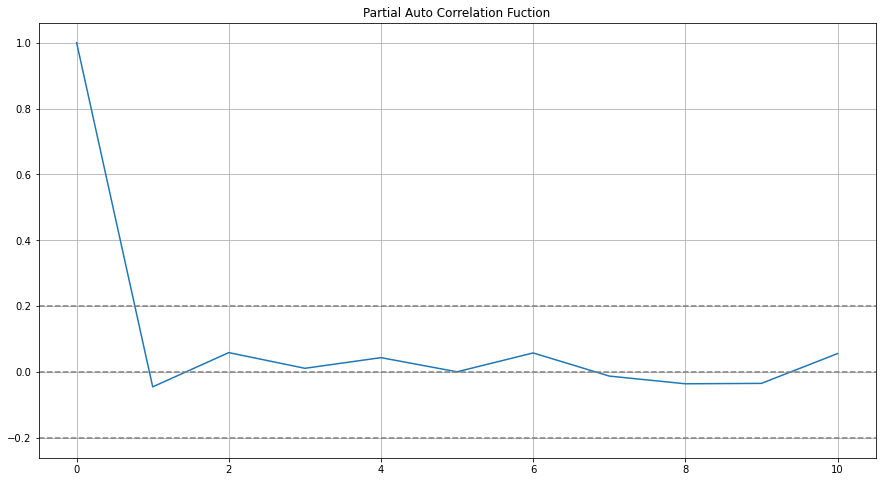

In [9]:
#Partial Auto Correlation Fuction #p

plt.plot(np.arange(pacf(tslma, nlags=10).shape[0]),pacf(tslma, nlags=10))
plt.axhline(y=0, linestyle='--', c='gray')
plt.axhline(y=-7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')
plt.axhline(y=7.96/np.sqrt(len(tslma)), linestyle='--',c='gray')

plt.title('Partial Auto Correlation Fuction')
plt.grid()
plt.show()

In [11]:
#Building ARIMA Model

Arima = ARIMA(tslma, order=(1,2,2))
Ar = Arima.fit()
# plt.plot(tslma, label=['Original'])
# plt.plot(Ar.fittedvalues,c='r', label=['Forecast'])
# plt.legend()
# plt.grid()

Ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1576
Model:                 ARIMA(1, 2, 2)   Log Likelihood                3486.984
Date:                Fri, 04 Mar 2022   AIC                          -6965.968
Time:                        10:02:51   BIC                          -6944.522
Sample:                    11-10-2017   HQIC                         -6957.998
                         - 03-04-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0467      0.019     -2.438      0.015      -0.084      -0.009
ma.L1         -1.9909      0.004   -443.305      0.000      -2.000      -1.982
ma.L2          0.9910      0.004    220.684      0.000       0.982       1.000
sigma2         0.0007   1.11e-05     62.188      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              7127.56
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                            -1.06
Prob(H) (two-sided):                  0.16   Kurtosis:                        13.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Inference: The Arima Model fits well on the time-series data with nearly perfect p-values. Let us now forcast the future data with the help of the trained ARIMA Model

5. Forecasting

In [12]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,1)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])
future_df.shape

(1577, 1)

In [13]:
Ar.predict(start =2500, end = 2600, dynamic= True)

2024-09-14   -0.021746
2024-09-15   -0.021767
2024-09-16   -0.021788
2024-09-17   -0.021809
2024-09-18   -0.021830
                ...   
2024-12-19   -0.023747
2024-12-20   -0.023768
2024-12-21   -0.023788
2024-12-22   -0.023809
2024-12-23   -0.023830
Freq: D, Name: predicted_mean, Length: 101, dtype: float64

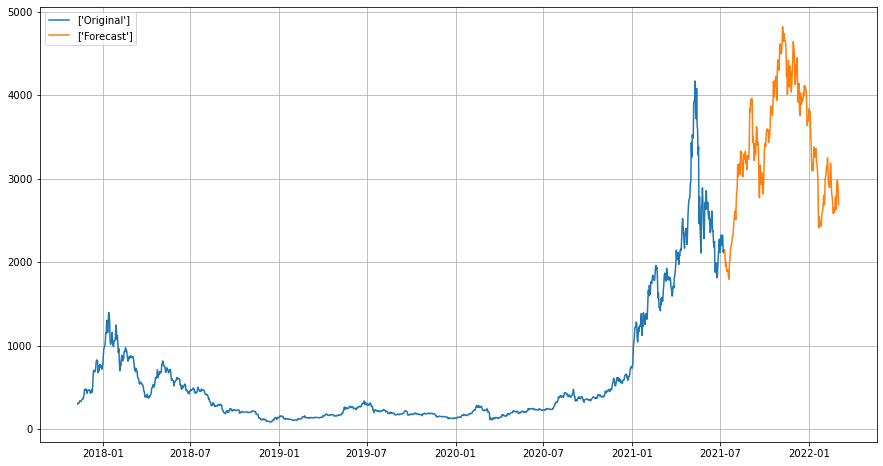

In [18]:
# Forecasting future predictions

future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

future_df=pd.concat([df,future_datest_df])

future_df['Price'] += Ar.predict(start =0, end = 2683, dynamic= True)

plt.plot(future_df[variable][:-260], label=['Original'])
plt.plot((future_df['Price'][-260:]+(1.08*ma.mean()[0])), label=['Forecast'])
plt.grid()
plt.legend()
plt.show()